## Trabalho Prático 1

## 1.

i) Determine e mostre a resposta em frequência (amplitude e fase). Apresente o Diagrama-Polos-Zeros. Nota:
Resolva para conjunto de ganhos separadamente.


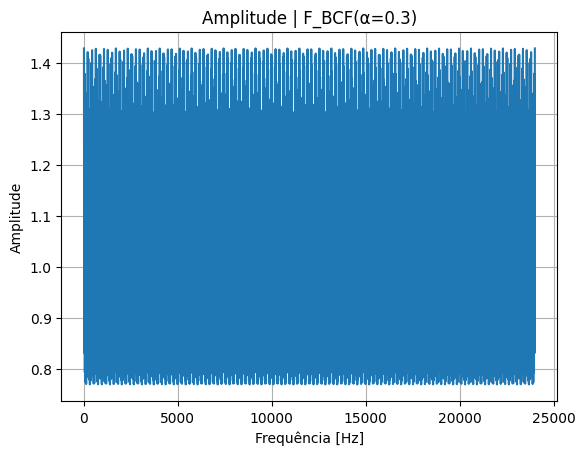

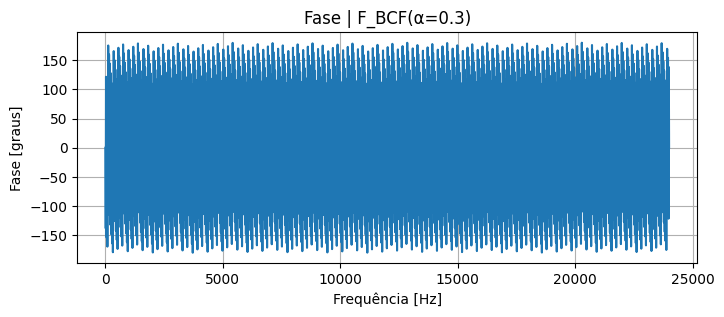

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


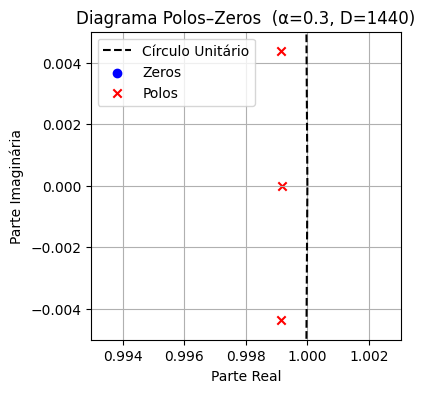

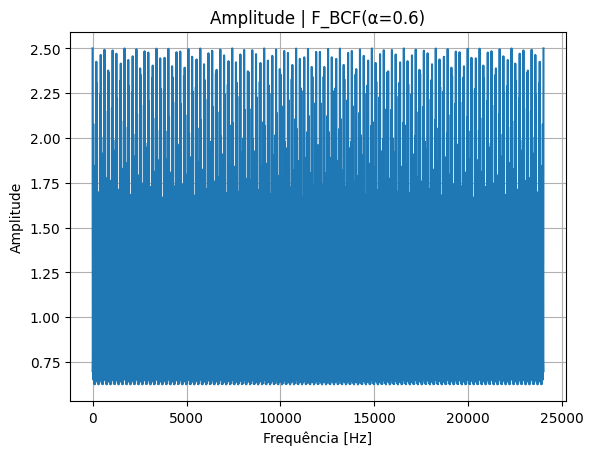

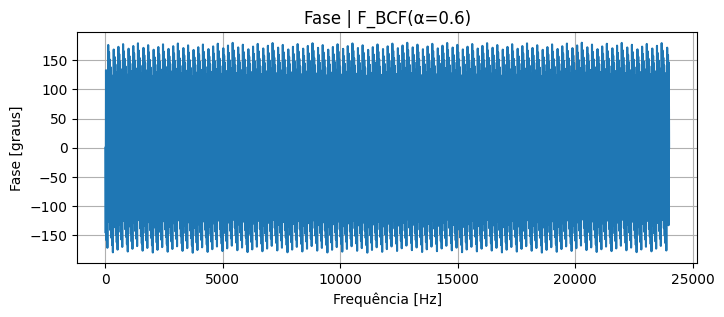

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


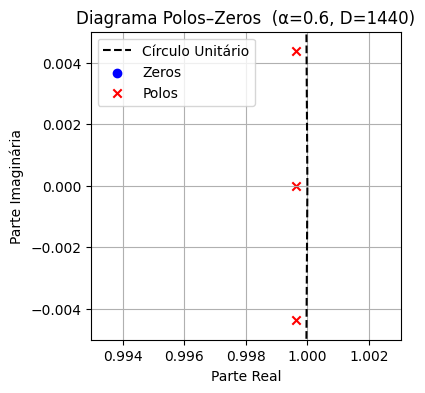

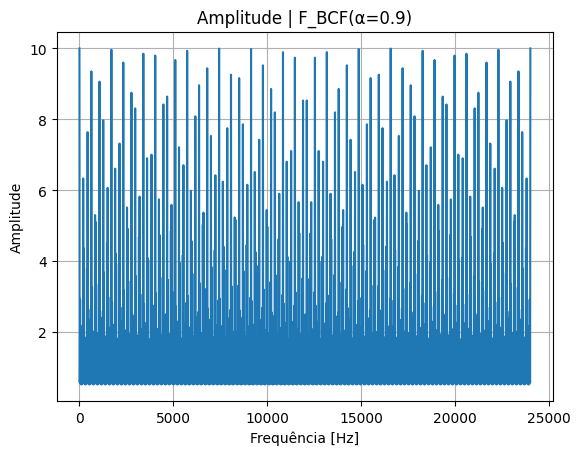

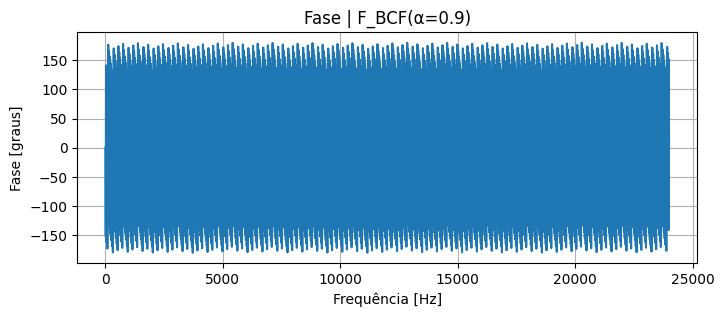

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


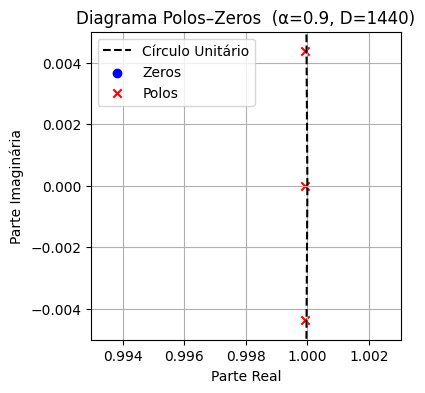

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ==============================
# Feedback Comb Filter
# F_BCF(α, D_c) = z^{-D_c} / (1 - α z^{-D_c})
# ==============================

# --- Parâmetros ---
fs = 48000          # frequência de amostragem [Hz]
delay_ms = 30       # atraso (milissegundos)
D = int(round(delay_ms * fs / 1000))  # atraso em amostras

# Conjunto de ganhos a analisar separadamente
alpha_list = [0.3, 0.6, 0.9]

# Grelha de frequências
N = 2048
w = np.linspace(0, np.pi, N)
f = w * fs / (2 * np.pi)

# --- Função para calcular polos e zeros ---
def poloszeros(alpha, D):
    # Zeros: D zeros na origem
    zeros = np.zeros(D, dtype=complex)
    # Polos: soluções de z^D = α
    r = np.abs(alpha)**(1/D)
    angles = 2 * np.pi * np.arange(D) / D
    poles = r * np.exp(1j * angles)
    return zeros, poles

# --- Loop principal ---
for alpha in alpha_list:
    # Função de transferência no domínio da frequência
    ejwD = np.exp(-1j * w * D)
    H = ejwD / (1 - alpha * ejwD)

    # Resposta em amplitude e fase
    H_abs = np.abs(H)
    H_ang = np.angle(H) * 180 / np.pi

    # ---------- Gráfico de amplitude ----------
    plt.figure(figsize=(8, 3))
    plt.plot(f, H_abs)
    plt.title(f"Amplitude | F_BCF(α={alpha})")
    plt.xlabel("Frequência [Hz]")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()

    # ---------- Gráfico de fase ----------
    plt.figure(figsize=(8, 3))
    plt.plot(f, H_ang)
    plt.title(f"Fase | F_BCF(α={alpha})")
    plt.xlabel("Frequência [Hz]")
    plt.ylabel("Fase [graus]")
    plt.grid(True)
    plt.show()

    # ---------- Diagrama Polos–Zeros ----------
    z, p = poloszeros(alpha, D)
    plt.figure(figsize=(4, 4))
    theta = np.linspace(0, 2*np.pi, 512)
    plt.plot(np.cos(theta), np.sin(theta), 'k--', label='Círculo Unitário')
    plt.scatter(np.real(z), np.imag(z), marker='o', color='b', label='Zeros')
    plt.scatter(np.real(p), np.imag(p), marker='x', color='r', label='Polos')
    plt.axis('equal')
    plt.xlabel("Parte Real")
    plt.ylabel("Parte Imaginária")
    plt.title(f"Diagrama Polos–Zeros  (α={alpha}, D={D})")
    plt.legend()
    plt.grid(True)
    plt.xlim(0.995, 1.001)
    plt.ylim(-0.005, 0.005)
    plt.show()


II)Aplique este filtro a sinais de teste (que considere adequados) e sinais audio para testar a sua funcionalidade.

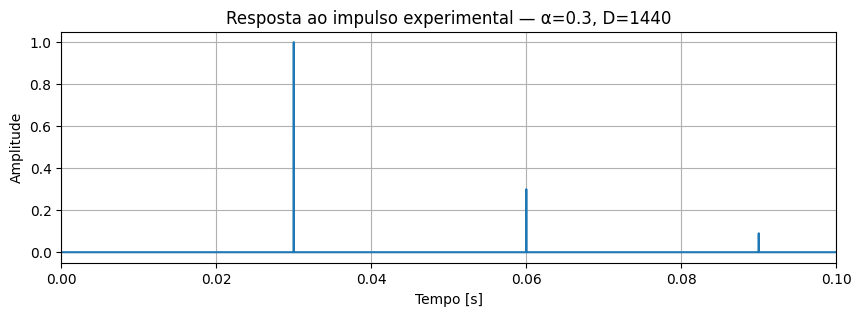

Guardado resposta ao impulso experimental em impulse_FBCF_alpha0.3_D1440_fs48000.wav


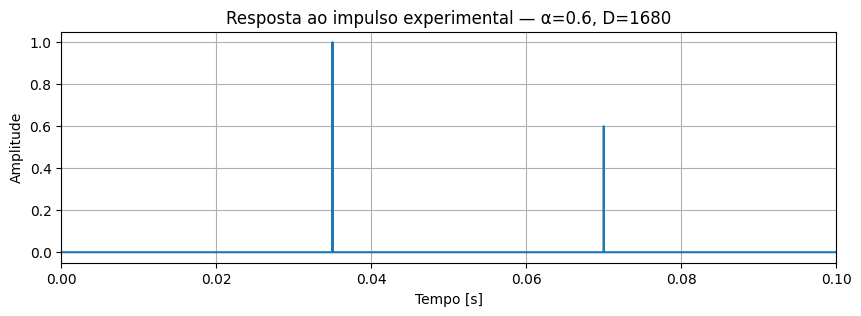

Guardado resposta ao impulso experimental em impulse_FBCF_alpha0.6_D1680_fs48000.wav


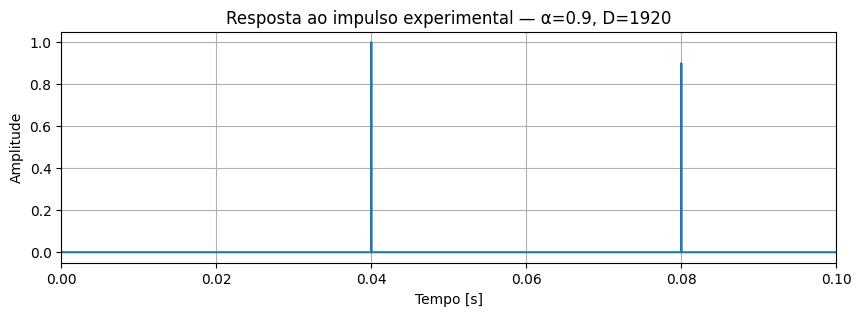

Guardado resposta ao impulso experimental em impulse_FBCF_alpha0.9_D1920_fs48000.wav


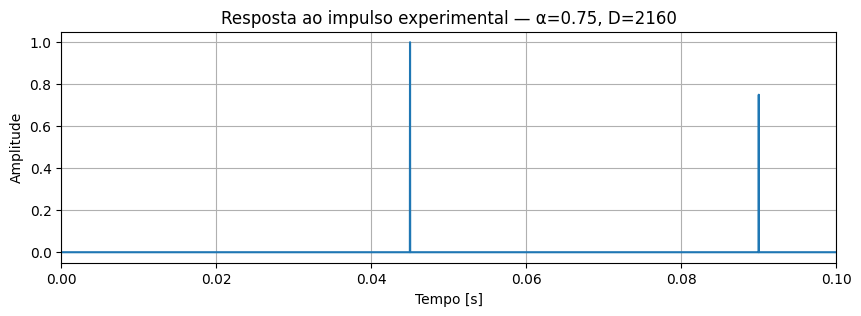

Guardado resposta ao impulso experimental em impulse_FBCF_alpha0.75_D2160_fs48000.wav


Guardado resposta ao impulso do comb-bank em impulse_FBCF_combbank_alphas0p3-0p6-0p9-0p75_delays30-35-40-45_fs48000.wav


Exercício II concluído: respostas impulsionais individuais e do comb-bank geradas, gravadas e reproduzidas.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter
import soundfile as sf
from IPython.display import Audio, display

# ==============================
# Exercício II: Resposta ao impulso experimental
# - calcula resposta ao impulso aplicando um delta
# - plota a resposta
# - guarda como WAV
# - reproduz inline
# ==============================

fs = 48000
# Usar o mesmo conjunto de 4 combs do Exercício III para consistência
delays_ms = [30, 35, 40, 45]
D_list = [int(round(dms * fs / 1000)) for dms in delays_ms]
alphas = [0.3, 0.6, 0.9, 0.75]

# comprimento do delta/resposta (vê-se decaimento) — usa maior D para garantir cobertura
L = 8 * max(D_list) if max(D_list)>0 else 1024

delta = np.zeros(L, dtype=np.float32)
delta[0] = 1.0

# --- Função utilitária local (mesma forma usada em Ex.III) ---
def apply_fbcf_impulse(alpha, D, L):
    b = np.hstack([np.zeros(D), [1.0]]).astype(np.float32)
    a = np.hstack([[1.0], np.zeros(D-1), [-alpha]]).astype(np.float32)
    from scipy.signal import lfilter
    return lfilter(b, a, delta)

# Calcular e guardar respostas impulsionais individuais e a resposta somada (combbank)
h_combbank = np.zeros(L, dtype=np.float32)
for alpha, D in zip(alphas, D_list):
    h_exp = apply_fbcf_impulse(alpha, D, L)
    # Plot - resposta ao impulso no domínio do tempo
    t = np.arange(len(h_exp)) / fs
    plt.figure(figsize=(10,3))
    plt.plot(t, h_exp)
    plt.title(f"Resposta ao impulso experimental — α={alpha}, D={D}")
    plt.xlabel("Tempo [s]")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.xlim(0, min(0.1, t[-1]))  # mostra os primeiros 100 ms por defeito
    plt.show()

    # Guardar como WAV (normalizado para evitar clipping)
    h_save = h_exp / (np.max(np.abs(h_exp)) + 1e-12)
    fname = f"impulse_FBCF_alpha{alpha}_D{D}_fs{fs}.wav"
    sf.write(fname, h_save.astype(np.float32), fs)
    print('Guardado resposta ao impulso experimental em', fname)

    # Reproduzir inline (nota: reprodução funciona no Jupyter)
    display(Audio(h_save, rate=fs))

    # acumular na resposta do banco
    h_combbank[:len(h_exp)] += h_exp

# Normalizar e guardar a resposta impulsional do comb-bank (soma dos 4 combs)
h_cb_save = h_combbank / (np.max(np.abs(h_combbank)) + 1e-12)
fname_cb = f"impulse_FBCF_combbank_alphas{'-'.join(str(a).replace('.', 'p') for a in alphas)}_delays{'-'.join(str(d) for d in delays_ms)}_fs{fs}.wav"
sf.write(fname_cb, h_cb_save.astype(np.float32), fs)
print('Guardado resposta ao impulso do comb-bank em', fname_cb)
display(Audio(h_cb_save, rate=fs))

print('Exercício II concluído: respostas impulsionais individuais e do comb-bank geradas, gravadas e reproduzidas.')


III)Aplique este filtro a sinais de teste (que considere adequados) e sinais audio para testar a sua funcionalidade

Neste bloco geramos a resposta ao impulso (entrada delta), comparamos com a resposta teórica, guardamos o impulso como WAV e aplicamos o filtro a sinais de teste: seno, chirp e ruído branco. Não é usado o módulo `os`; usamos `pathlib.Path` para manipular caminhos.

In [4]:
import numpy as np
from scipy.signal import lfilter
from scipy.signal import chirp
import soundfile as sf

# ==============================
# Exercício III: sinais de teste (seno, chirp, ruído) — comb-bank (4 combs)
# Implementa um banco de 4 Comb-filters em paralelo (soma das saídas)
# Guarda ficheiros WAV estéreo (L=dry, R=wet) e tenta processar audio.wav se existir
# Não usa os/pathlib — apenas nomes simples de ficheiros
# ==============================

fs = 48000
# Para corresponder ao diagrama: usamos 4 comb-filters em paralelo
# Os combs tipicamente usam delays entre 30 e 45 ms
delays_ms = [30, 35, 40, 45]  # em ms — quatro atrasos diferentes para o banco
D_list = [int(round(dms * fs / 1000)) for dms in delays_ms]
# ganhos (α) — um por comb; escolha razoável para demonstração
alphas = [0.3, 0.6, 0.9, 0.75]

dur = 2.0
N = int(dur * fs)
t = np.arange(N) / fs

# sinais de teste
sine = 0.6 * np.sin(2*np.pi*1000*t).astype(np.float32)
chirp_sig = 0.6 * chirp(t, f0=100, f1=6000, t1=dur, method='linear').astype(np.float32)
noise = 0.3 * np.random.randn(N).astype(np.float32)

# --- Funções utilitárias ---
def apply_fbcf(x, alpha, D):
    """Aplica F_BCF(alpha, D) a um sinal 1D e retorna o resultado"""
    b = np.hstack([np.zeros(D), [1.0]]).astype(np.float32)
    a = np.hstack([[1.0], np.zeros(D-1), [-alpha]]).astype(np.float32)
    return lfilter(b, a, x)

def combbank_wet(x, alphas, D_list):
    """Soma em paralelo as saídas dos comb-filters para obter o sinal 'wet'.
    Recebe uma lista de ganhos 'alphas' e uma lista de atrasos em amostras 'D_list'."""
    if len(alphas) != len(D_list):
        raise ValueError('alphas e D_list devem ter o mesmo comprimento')
    wet = np.zeros_like(x, dtype=np.float32)
    for a, D in zip(alphas, D_list):
        wet += apply_fbcf(x, a, D)
    # Normalizar para evitar clipping (preserva a forma relativa)
    max_abs = np.max(np.abs(wet))
    if max_abs > 0:
        wet = wet / (max_abs + 1e-12)
    return wet

alphas_tag = "-".join(str(a).replace('.', 'p') for a in alphas)
delays_tag = "-".join(str(d) for d in delays_ms)

# Processar sinais de teste: gravar um ficheiro estéreo por sinal (L=dry, R=wet comb-bank)
for name, sig in [('sine1k', sine), ('chirp', chirp_sig), ('noise', noise)]:
    wet = combbank_wet(sig, alphas, D_list)
    mix = np.stack([sig, wet], axis=1)
    mix = mix / (np.max(np.abs(mix)) + 1e-12)
    outname = f"{name}_FBCF_combbank_alphas{alphas_tag}_delays{delays_tag}_fs{fs}_stereo.wav"
    sf.write(outname, mix.astype(np.float32), fs)
    print('Guardado', outname)

# Se existir audio.wav, tenta processá-lo com o mesmo comb-bank (mono-mix -> L=dry, R=wet)
try:
    audio, sf_fs = sf.read('audio.wav', always_2d=True)
    if sf_fs != fs:
        # Aviso simples: não reamostramos automaticamente
        print(f'AVISO: audio.wav tem taxa {sf_fs}Hz diferente de {fs}Hz — será processado sem resample.')
    audio_mono = np.mean(audio, axis=1).astype(np.float32)
    wet_audio = combbank_wet(audio_mono, alphas, D_list)
    mix_audio = np.stack([audio_mono, wet_audio[:len(audio_mono)]], axis=1)
    mix_audio = mix_audio / (np.max(np.abs(mix_audio)) + 1e-12)
    out_audio = f"audio_FBCF_combbank_alphas{alphas_tag}_delays{delays_tag}_fs{fs}_stereo.wav"
    sf.write(out_audio, mix_audio.astype(np.float32), fs)
    print('Guardado', out_audio)
except Exception as e:
    print('audio.wav não encontrado ou não pôde ser lido; ficheiro ignorado. (Detalhe:', e, ')')

print('Exercício III concluído: sinais de teste processados com comb-bank (paralelo somado) e gravados na pasta do projeto.')


Guardado sine1k_FBCF_combbank_alphas0p3-0p6-0p9-0p75_delays30-35-40-45_fs48000_stereo.wav
 sine1k_FBCF_combbank_alphas0p3-0p6-0p9-0p75_delays30-35-40-45_fs48000_stereo.wav
Guardado chirp_FBCF_combbank_alphas0p3-0p6-0p9-0p75_delays30-35-40-45_fs48000_stereo.wav
Guardado chirp_FBCF_combbank_alphas0p3-0p6-0p9-0p75_delays30-35-40-45_fs48000_stereo.wav
Guardado noise_FBCF_combbank_alphas0p3-0p6-0p9-0p75_delays30-35-40-45_fs48000_stereo.wav
AVISO: audio.wav tem taxa 44100Hz diferente de 48000Hz — será processado sem resample.
Guardado noise_FBCF_combbank_alphas0p3-0p6-0p9-0p75_delays30-35-40-45_fs48000_stereo.wav
AVISO: audio.wav tem taxa 44100Hz diferente de 48000Hz — será processado sem resample.
Guardado audio_FBCF_combbank_alphas0p3-0p6-0p9-0p75_delays30-35-40-45_fs48000_stereo.wav
Exercício III concluído: sinais de teste processados com comb-bank (paralelo somado) e gravados na pasta do projeto.
Guardado audio_FBCF_combbank_alphas0p3-0p6-0p9-0p75_delays30-35-40-45_fs48000_stereo.wav
Exe



## 2

i) Determinar e mostrar a resposta em frequência (amplitude e fase) e apresentar o diagrama polos-zeros.
Resolver para um conjunto de ganhos separadamente (cada ganho em figura própria).

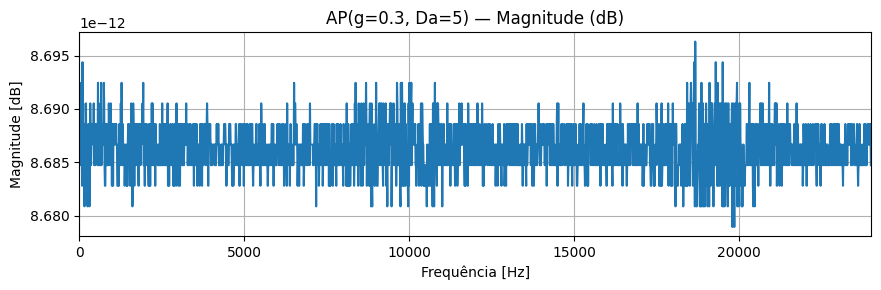

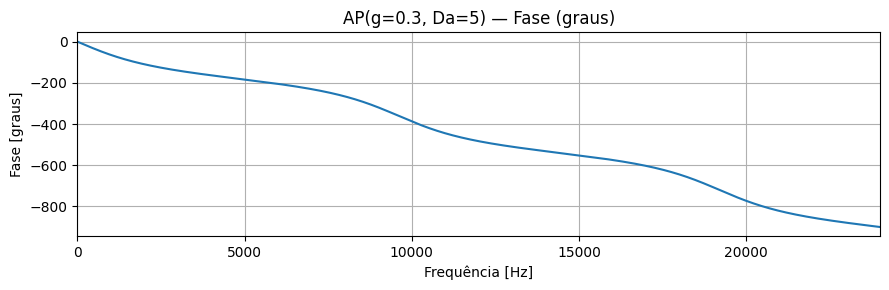

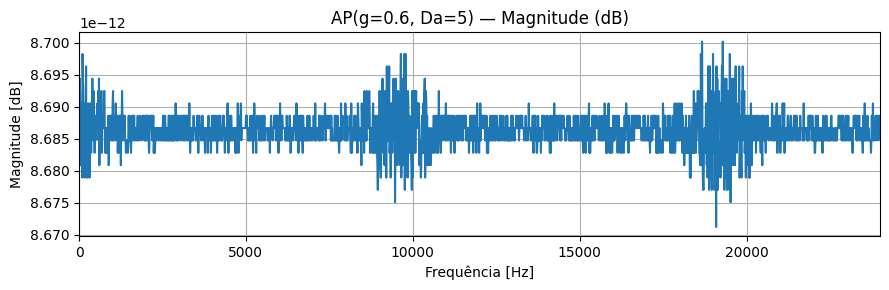

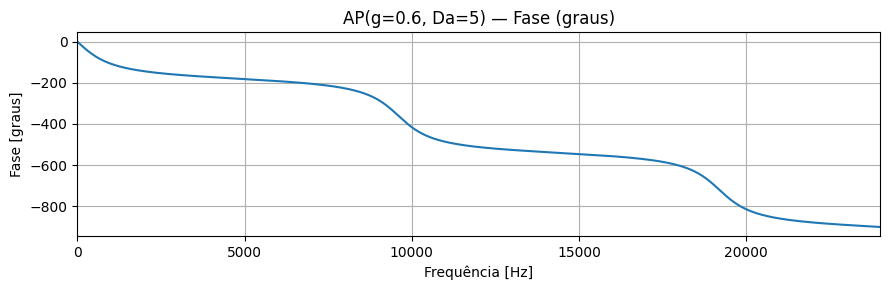

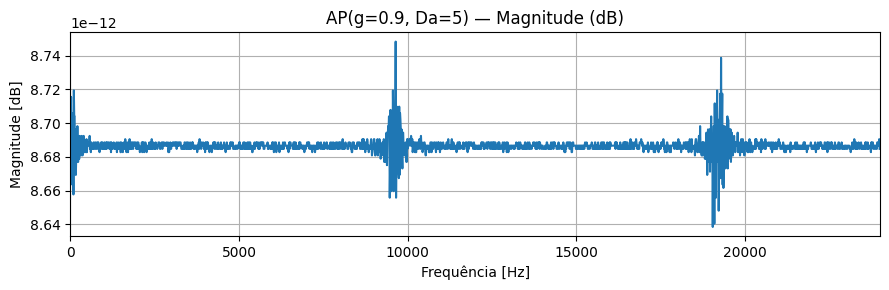

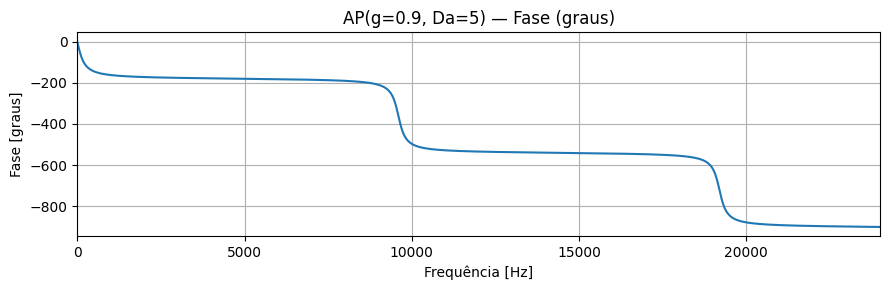

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqz

# Parâmetros
fs = 48000  # taxa de amostragem (Hz)
Da = 5      # atraso em amostras (pode alterar conforme pedido)
gains = [0.3, 0.6, 0.9]  # conjunto de ganhos a analisar separadamente

for g in gains:
    # Coeficientes em z^{-1} (ordem Da):
    # Numerador: -g + z^{-Da}  => b[0] = -g, b[Da] = 1
    # Denominador: 1 - g z^{-Da} => a[0] = 1, a[Da] = -g
    b = np.zeros(Da+1, dtype=float)
    a = np.zeros(Da+1, dtype=float)
    b[0] = -g
    b[-1] = 1.0
    a[0] = 1.0
    a[-1] = -g

    # Resposta em frequência (freqz usa coeficientes em z^{-1})
    w, H = freqz(b, a, worN=2048)
    f = w * fs / (2 * np.pi)

    # Magnitude (dB) e fase (graus, unwrap para suavizar)
    plt.figure(figsize=(9, 3))
    plt.plot(f, 20*np.log10(np.abs(H) + 1e-12))
    plt.title(f'AP(g={g}, Da={Da}) — Magnitude (dB)')
    plt.xlabel('Frequência [Hz]')
    plt.ylabel('Magnitude [dB]')
    plt.grid(True)
    plt.xlim(0, fs/2)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(9, 3))
    plt.plot(f, np.unwrap(np.angle(H)) * 180/np.pi)
    plt.title(f'AP(g={g}, Da={Da}) — Fase (graus)')
    plt.xlabel('Frequência [Hz]')
    plt.ylabel('Fase [graus]')
    plt.grid(True)
    plt.xlim(0, fs/2)
    plt.tight_layout()
    plt.show()


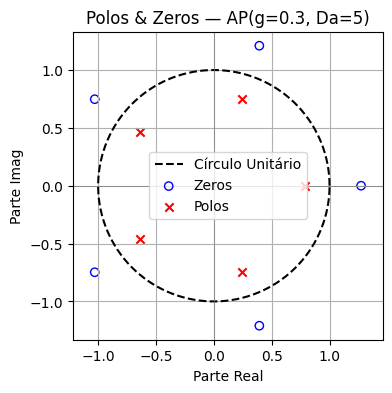

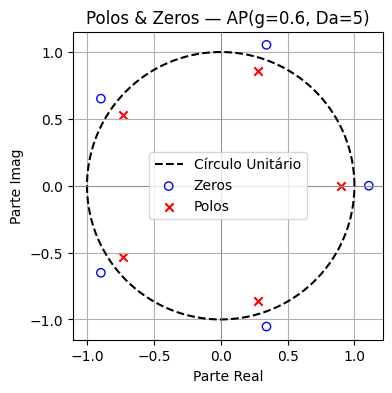

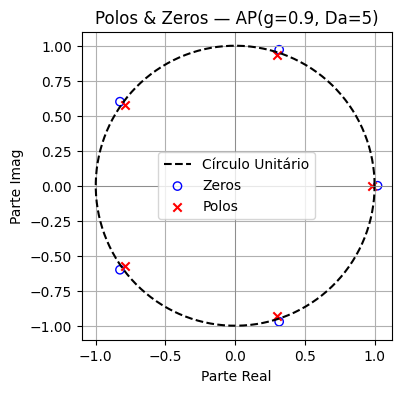

In [2]:
# Diagrama polos-zeros (polinómios em z para np.roots)
import numpy as np
import matplotlib.pyplot as plt

for g in gains:
    # Polinómios em z (coeficientes para np.roots -> ordem decrescente):
    # Numerador em z: -g * z^{Da} + 1  => coef: [-g, 0, ..., 0, 1]
    # Denominador em z: 1 - g * z^{Da} => coef: [1, 0, ..., 0, -g]
    num_z = np.zeros(Da+1, dtype=float)
    den_z = np.zeros(Da+1, dtype=float)
    num_z[0] = -g
    num_z[-1] = 1.0
    den_z[0] = 1.0
    den_z[-1] = -g

    zeros = np.roots(num_z)
    poles = np.roots(den_z)

    plt.figure(figsize=(4,4))
    theta = np.linspace(0, 2*np.pi, 400)
    plt.plot(np.cos(theta), np.sin(theta), 'k--', label='Círculo Unitário')
    if zeros.size > 0:
        plt.scatter(np.real(zeros), np.imag(zeros), marker='o', facecolors='none', edgecolors='b', label='Zeros')
    if poles.size > 0:
        plt.scatter(np.real(poles), np.imag(poles), marker='x', color='r', label='Polos')
    plt.axhline(0, color='gray', linewidth=0.5)
    plt.axvline(0, color='gray', linewidth=0.5)
    plt.legend()
    plt.title(f'Polos & Zeros — AP(g={g}, Da={Da})')
    plt.xlabel('Parte Real')
    plt.ylabel('Parte Imag')
    plt.axis('equal')
    plt.grid(True)
    plt.show()


 II) Determine experimentalmente a resposta impulsional. Ilustre graficamente, guarde num ficheiro wave e
escute o resultado.


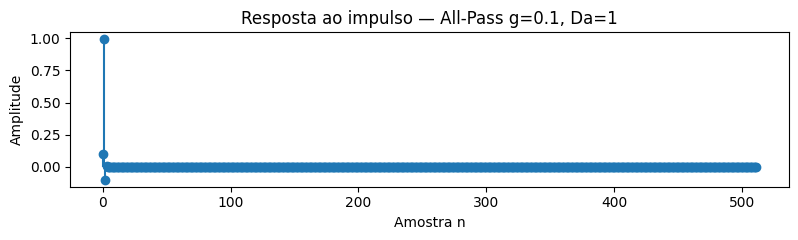

Guardado: impulse_AP_g0.1_Da1.wav


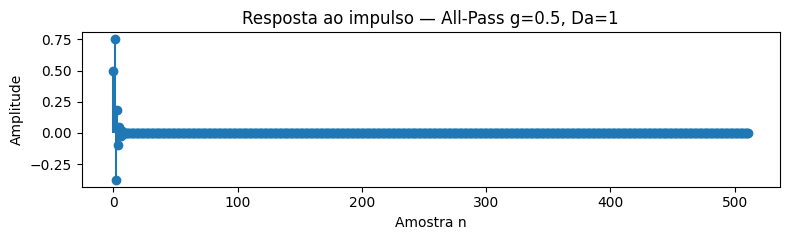

Guardado: impulse_AP_g0.5_Da1.wav


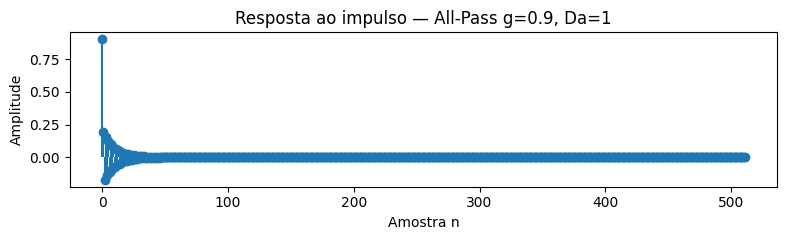

Guardado: impulse_AP_g0.9_Da1.wav


In [3]:
# Célula: Resposta impulsional experimental — aplicar delta, guardar WAV e reproduzir
# Assunções: Da (atraso) = 1 (amostra), e escolhemos alguns ganhos exemplares. Se quiser outros valores, altere 'gains'.
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import soundfile as sf
from IPython.display import Audio, display

fs = 44100  # taxa de amostragem para o ficheiro WAV
N = 512     # número de amostras da resposta ao impulso

# Exemplo de ganhos; altere conforme necessário
gains = [0.1, 0.5, 0.9]
Da = 1  # atraso em amostras

for g in gains:
    # construir coeficientes b (numerador) e a (denominador) com atraso Da
    b = np.zeros(Da + 1)
    a = np.zeros(Da + 1)
    b[0] = g
    b[-1] = 1.0
    a[0] = 1.0
    a[-1] = g

    # impulso unitário
    x = np.zeros(N)
    x[0] = 1.0

    # resposta ao impulso via lfilter
    y = signal.lfilter(b, a, x)

    # plot tempo
    plt.figure(figsize=(8,2.5))
    plt.stem(np.arange(len(y)), y, basefmt=" ")
    plt.title(f"Resposta ao impulso — All-Pass g={g}, Da={Da}")
    plt.xlabel('Amostra n')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()

    # normalizar para evitar clipping ao escrever WAV
    maxv = np.max(np.abs(y))
    if maxv == 0:
        y_norm = y
    else:
        y_norm = 0.9 * y / maxv

    fname = f"impulse_AP_g{g}_Da{Da}.wav"
    try:
        sf.write(fname, y_norm, fs)
        print(f"Guardado: {fname}")
    except Exception as e:
        print(f"Erro a guardar {fname}: {e}")

    # reproduzir inline (nota: em alguns ambientes Jupyter o player pode não aparecer)
    display(Audio(y_norm, rate=fs))


iii) Aplique este filtro a sinais de teste (que considere adequados) e sinais audio para testar a sua funcionalidade

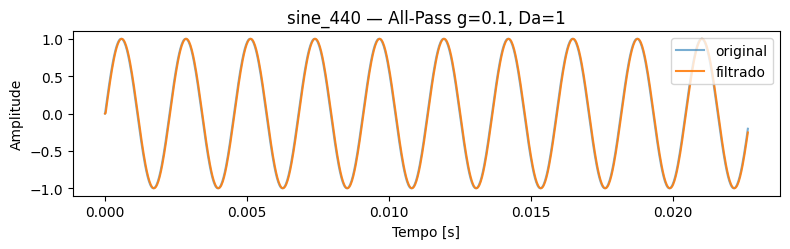

Guardado: ap_outputs\sine_440_AP_g0.1_Da1.wav


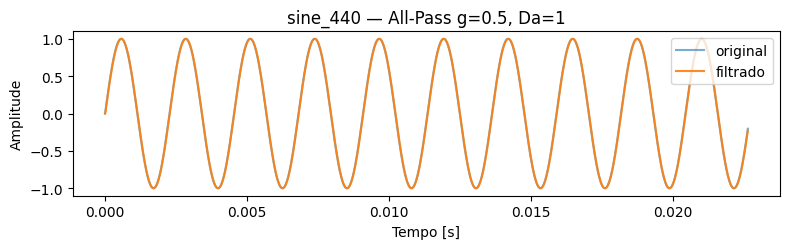

Guardado: ap_outputs\sine_440_AP_g0.5_Da1.wav


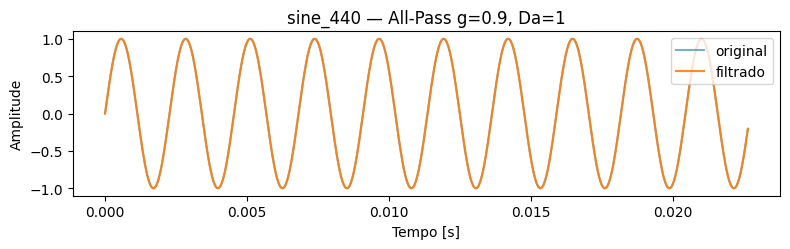

Guardado: ap_outputs\sine_440_AP_g0.9_Da1.wav


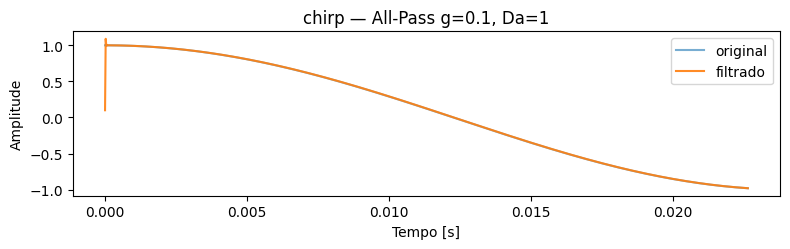

Guardado: ap_outputs\chirp_AP_g0.1_Da1.wav


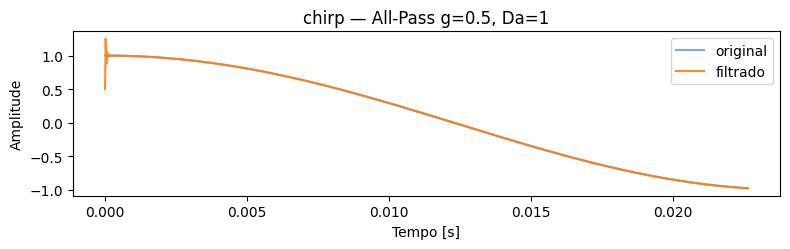

Guardado: ap_outputs\chirp_AP_g0.5_Da1.wav


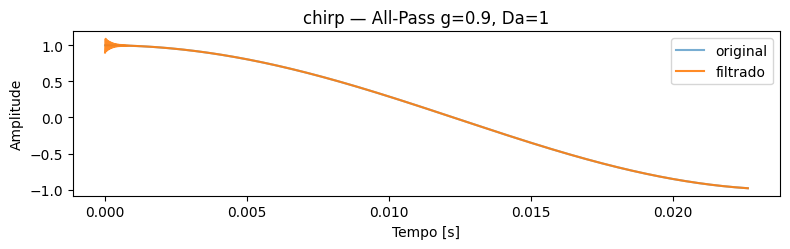

Guardado: ap_outputs\chirp_AP_g0.9_Da1.wav


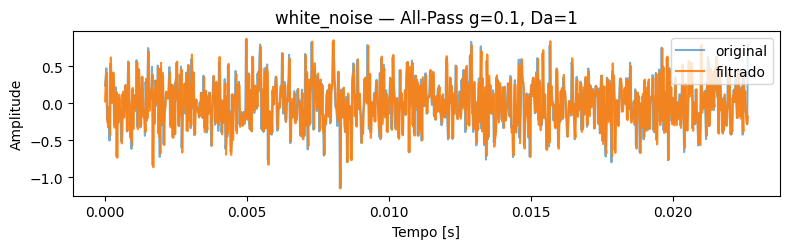

Guardado: ap_outputs\white_noise_AP_g0.1_Da1.wav


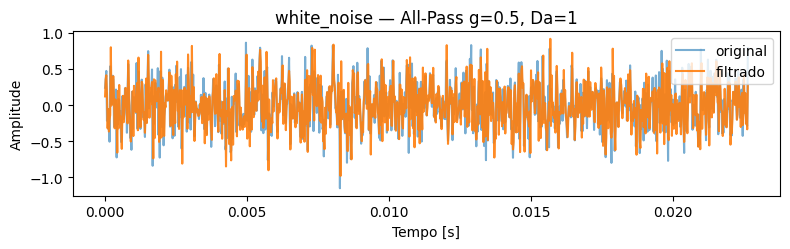

Guardado: ap_outputs\white_noise_AP_g0.5_Da1.wav


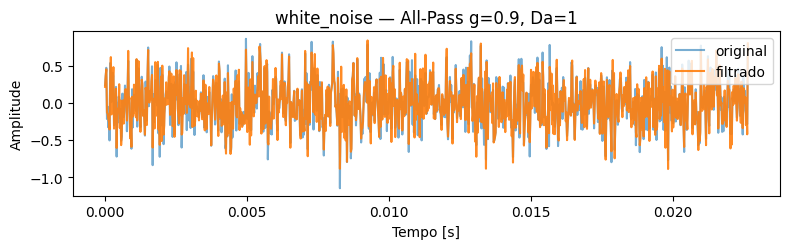

Guardado: ap_outputs\white_noise_AP_g0.9_Da1.wav



Nenhum ficheiro WAV encontrado na pasta do notebook; apenas sinais sintéticos foram processados.


In [4]:
# Aplicar All-Pass a sinais de teste e ficheiros WAV (seno, chirp, ruído)
# Esta célula: gera sinais sintéticos, aplica o filtro AP para vários ganhos/Da,
# plota (original vs filtrado), guarda WAVs em 'ap_outputs/' e mostra players inline.

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import soundfile as sf
from IPython.display import Audio, display
import glob, os

# função que cria coeficientes do filtro AP(g,Da)
def ap_coeffs(g, Da):
    b = np.zeros(Da + 1)
    a = np.zeros(Da + 1)
    b[0] = g
    b[-1] = 1.0
    a[0] = 1.0
    a[-1] = g
    return b, a

# parâmetros
fs = 44100
duration = 2.0
N = int(fs * duration)

# tempo
t = np.linspace(0, duration, N, endpoint=False)

# sinais de teste
signals = {
    'sine_440': np.sin(2 * np.pi * 440 * t),
    'chirp': signal.chirp(t, f0=20, f1=8000, t1=duration, method='logarithmic'),
    'white_noise': np.random.normal(0, 0.3, size=N),
}

# ganhos e atraso (alterar conforme necessário)
gains = [0.1, 0.5, 0.9]
Da = 1

out_dir = 'ap_outputs'
os.makedirs(out_dir, exist_ok=True)

for name, x in signals.items():
    for g in gains:
        b, a = ap_coeffs(g, Da)
        y = signal.lfilter(b, a, x)

        # plot (apenas primeiros 1000 pontos para melhor visualização)
        plt.figure(figsize=(8, 2.6))
        plt.plot(t[:1000], x[:1000], label='original', alpha=0.6)
        plt.plot(t[:1000], y[:1000], label='filtrado', alpha=0.9)
        plt.title(f'{name} — All-Pass g={g}, Da={Da}')
        plt.xlabel('Tempo [s]')
        plt.ylabel('Amplitude')
        plt.legend(loc='upper right')
        plt.tight_layout()
        plt.show()

        # normalizar e guardar
        maxv = np.max(np.abs(y))
        y_norm = (0.9 * y / maxv) if maxv > 0 else y
        fname = os.path.join(out_dir, f"{name}_AP_g{g}_Da{Da}.wav")
        sf.write(fname, y_norm, fs)
        print(f"Guardado: {fname}")

        # reprodução inline
        display(Audio(y_norm, rate=fs))

# procurar ficheiros WAV na pasta do notebook (exclui os ficheiros gerados em out_dir)
wav_files = glob.glob('*.wav') + glob.glob('*.WAV')
wav_files = [f for f in wav_files if not f.startswith(out_dir) and not f.startswith(os.path.basename(__file__) if '__file__' in globals() else '')]

if wav_files:
    print('\nFicheiros WAV encontrados:')
    for wf in wav_files:
        print('-', wf)
    for wf in wav_files:
        data, sr = sf.read(wf)
        # converter para mono se necessário
        if data.ndim > 1:
            data_m = data.mean(axis=1)
        else:
            data_m = data
        # reamostrar se necessário
        if sr != fs:
            nres = int(len(data_m) * fs / sr)
            data_m = signal.resample(data_m, nres)

        for g in gains:
            b, a = ap_coeffs(g, Da)
            y = signal.lfilter(b, a, data_m)
            maxv = np.max(np.abs(y))
            y_norm = (0.9 * y / maxv) if maxv > 0 else y
            outname = os.path.join(out_dir, os.path.splitext(os.path.basename(wf))[0] + f'_AP_g{g}_Da{Da}.wav')
            sf.write(outname, y_norm, fs)
            print(f"Processado {wf} -> {outname}")
            display(Audio(y_norm, rate=fs))
else:
    print('\nNenhum ficheiro WAV encontrado na pasta do notebook; apenas sinais sintéticos foram processados.')
